# Perkenalan

___
Milestone 2

Nama: Fadhiil Dzaki Mulyana<br>
Batch: HCK-22

Notebook ini akan digunakan untuk melakukan analisis  mengenai hal hal yang berhubungan kecenderungan orang untuk melakukan deposit dan membangun model machine learnning yang dapat memprediksi orang-orang yang cenderung berdeposit.
___

**Link App:**<br>
Apartment Price Prediction

**Dataset Description:**<br>
Source: [Kaggle | Sao Paulo Real Estate](https://www.kaggle.com/datasets/argonalyst/sao-paulo-real-estate-sale-rent-april-2019)

Dataset merupakan representasi dari harga properti pada bulan April 2019. Dataset ini berisi sekitar 13.000 apartemen dijual dan disewakan di kota São Paulo, Brasil. Data berasal dari berbagai sumber, khususnya situs web penjualan real estate.

| Nama Kolom        | Deskripsi                                                                                         |
|-------------------|---------------------------------------------------------------------------------------------------|
| **Price**         | Harga akhir yang diiklankan dalam mata uang Brazilian Real (R$).                                  |
| **Condo**         | Biaya bulanan untuk kondominium, dengan nilai unknown ditandai sebagai nol.                       |
| **Size**          | Luas properti dalam meter persegi (m²), hanya mencakup area pribadi.                              |
| **Rooms**         | Jumlah kamar tidur di apartemen.                                                                  |
| **Toilets**       | Jumlah kamar mandi (semua jenis kamar mandi).                                                     |
| **Suites**        | Jumlah kamar tidur yang memiliki kamar mandi pribadi (ensuite).                                   |
| **Parking**       | Jumlah tempat parkir yang tersedia untuk apartemen.                                               |
| **Elevator**      | Nilai biner: 1 jika ada lift di gedung, 0 jika tidak ada.                                         |
| **Furnished**     | Nilai biner: 1 jika apartemen dalam kondisi berperabotan lengkap, 0 jika tidak.                   |
| **Swimming Pool** | Nilai biner: 1 jika apartemen memiliki kolam renang, 0 jika tidak ada.                            |
| **New**           | Nilai biner: 1 jika properti tergolong baru, 0 jika tidak.                                        |
| **District**      | Nama wilayah atau lingkungan tempat properti berada, contoh: Itaim Bibi/São Paulo.                |
| **Negotiation Type** | Jenis negosiasi properti, apakah untuk dijual atau disewakan.                                  |
| **Property Type** | Jenis properti, misalnya apartemen, rumah, dll.                                                   |
| **Latitude**      | Lokasi geografis (garis lintang) properti.                                                        |
| **Longitude**     | Lokasi geografis (garis bujur) properti.                                                          |


**Background:**<br>
Sao Paulo, Brazil, adalah salah satu kota terbesar dan pusat ekonomi utama di Amerika Selatan. Sebagai kota metropolitan yang terus berkembang, kebutuhan akan hunian seperti apartemen semakin meningkat, terutama di daerah pusat bisnis dan kawasan populer. Bagi calon pembeli dan investor, estimasi harga apartemen yang akurat menjadi faktor penting dalam pengambilan keputusan. Dengan demikian, model prediksi harga apartemen yang andal dapat membantu calon pembeli dan pelaku bisnis properti memahami tren harga dan membuat keputusan yang lebih terinformasi.

**Problem Statement:**<br>
Membangun model regresi untuk memprediksi estimasi harga jual/sewa apartment di Sao Paulo, Brazil dengan error RMSE di bawah R$5.000. Model akan dibangun dalam 3 bulan menggunakan data apartemen yang mencakup faktor signifikan seperti luas, jumlah kamar tidur, dan lokasi, untuk membantu calon pembeli mendapatkan estimasi harga yang akurat.

**Sumber Informasi:**<br>
- [The Rio Times](https://www.riotimesonline.com/real-estate-trends-in-sao-paulo-a-study-of-rising-values/)
- [Benoit Properties International](https://www.benoitproperties.com/destinations/sao-paulo/)
- [The Latinvestor](https://thelatinvestor.com/blogs/news/sao-paulo-property)

**Problem Breakdown:**<br>

# Libraries
Bagian ini berisi mengenai library-library dan fungsi-fungsi yang digunakan.

## Library

In [87]:
# data manipulation
import pandas as pd
import numpy as np
from unidecode import unidecode

# map
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# prep
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Stats
from scipy.stats import spearmanr, kendalltau, mannwhitneyu

# model
# Importing required libraries and models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Evaluasi
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score

# ignore warning
import warnings
warnings.filterwarnings('ignore')

## Function

In [3]:
# OVERALL
# overview
def check_overview(df):
    '''
    df_overview adalah fungsi yang digunakan untuk melihat informasi seputar dataset.

    Argumen:
    df = dataset yang digunakan.

    Output:
    Informasi overall dataset, missing value, duplicated value dan jumlah unique value setiap kolom.
    '''
    # df overview
    print(df.info())

    # cek missing value
    print(f"\nmissing values: {round(((df.isna().sum().sum())/len(df))*100, 2)}% \n{df.isna().sum()[df.isna().sum()>0]}")

    # cek duplicated value
    print(f"\nduplicated values: {round(((df.duplicated().sum())/len(df))*100,2)}% \n{df.duplicated().sum()}\n")

    # cek nama kolom & jumlah unique value
    for col in df:
        print(f'{col}-#nunique: {df[col].nunique()}')

# fungsi cek deskriptif stats
def check_deskriptif(df, kolom):
    '''
    Fungsi ini digunakan untuk mengetahui statistik deskriptif.

    Argumen:
    - df = DataFrame
    - kolom = List dari kolom numerik

    Return:
    - DataFrame yang berisi deskriptif statistik data.
    '''
    # deskriptif stats
    deskriptif = df[kolom].describe().T

    # List untuk menyimpan nilai
    skewness_values = []
    jenis_skewness = []

    # Loop untuk menghitung skewness dan kurtosis setiap kolom
    for i in kolom:
        # Menghitung skewness
        skew = df[i].skew()
        skewness_values.append(skew)
        
        # Menentukan jenis skewness
        if -0.5 <= skew <= 0.5:
            jenis_skewness.append('normal')
        else:
            jenis_skewness.append('skewed')

    # Membuat kolom baru dalam deskriptif
    deskriptif['skewness'] = skewness_values
    deskriptif['jenis_skewness'] = jenis_skewness

    return deskriptif

# fungsi cek outlier
def check_outlier(df, kolom):
    '''
    argumen:
    df = dataframe
    kolom = kolom numerik [list]
    multiplier = pengkali dalam metode IQR (1.5 / 3)
    '''
    # mengecek deskriptif stats
    deskriptif = check_deskriptif(df,kolom)

    # batas atas
    upper_fence = []
    #batas bawah
    lower_fence = []
    # persentase outlier
    percent_outlier = []

    # looping untuk mengisi list kosong
    for i in kolom:
        # bentuk distribusi
        bentuk_dist = deskriptif['jenis_skewness'][i]
        # besar skewness
        besar_skew = deskriptif['skewness'][i]

        # jika bentuk distribusi skew
        if bentuk_dist == 'skewed':
            # jika outlier kecil
            if -1 < besar_skew < 1:
                # mencari Q1,Q2 dan IQR
                Q3 = df[i].quantile(0.75)
                Q1 = df[i].quantile(0.25)
                IQR = Q3-Q1
                
                # menghitung boundaries
                batas_bawah = Q1-1.5*IQR
                batas_atas = Q3+1.5*IQR
            # jika outlier extreeme
            else:
                # mencari Q1,Q2 dan IQR
                Q3 = df[i].quantile(0.75)
                Q1 = df[i].quantile(0.25)
                IQR = Q3-Q1
                # menghitung boundaries
                batas_bawah = Q1-3*IQR
                batas_atas = Q3+3*IQR

        # jika bentuk distribusi normal
        else:
            # rata2 dan st. deviasi
            avg = df[i].mean()
            std = df[i].std()

            # boundaries
            batas_atas = avg + 3*std
            batas_bawah = avg - 3*std

        # menghitung persentase outlier
        persentase_out = ((len(df[df[i] > batas_atas]) / len(df) * 100) + (len(df[df[i] < batas_bawah]) / len(df) * 100))
        persentase_out = round(persentase_out,2)

        # boundaries adn percentage add
        lower_fence.append(batas_bawah)
        upper_fence.append(batas_atas)
        percent_outlier.append(persentase_out)

    # convert to df
    outlier = pd.DataFrame({
        'batas_atas': upper_fence,
        'batas_bawah': lower_fence,
        'persentase' : percent_outlier},
        index=kolom
        )
    # mengembalikan outlier
    return outlier

# STATS
# uji mann whitney
def uji_mannwhitney(df,kolom_1,kolom_2):
    '''
    argumen:
    kolom_1 = kolom yang ingin dibandingkan
    kolom_2 = kolom pembanding
    '''
    unique = df[kolom_1].unique()
    df_a = df.loc[df[kolom_1] == unique[0], kolom_2]
    df_b = df.loc[df[kolom_1] == unique[1], kolom_2]

    # Mann-Whitney U Test
    stat, p_value = mannwhitneyu(df_a, df_b)
    print(f"U-Statistic: {stat}, P-Value: {p_value}")

    # hasil
    print(f'tstat = {stat}')
    print(f'pvalue = {p_value}\n')

    # kondisi tolak H0
    if p_value < 0.05:
        print(f'H0 berhasil ditolak: terdapat perbedaan yang signifikan pada {kolom_1} dan {kolom_2}\n')
    # kondisi gagal tolak H0
    else:
        print(f'H0 gagal ditolak: TIDAK terdapat perbedaan yang signifikan pada {kolom_1} dan {kolom_2}\n')
    
    return stat,p_value

# uji spearman
def uji_spearman(df,kolom_1,kolom_2):
    # uji spearman
    corr_coef, p_value = spearmanr(df[kolom_1],df[kolom_2])

    # hasil
    print(f'koefisien corr = {corr_coef}')
    print(f'pvalue = {p_value}\n')

    if p_value < 0.05:
        print(f'H0 berhasil ditolak: {kolom_1} berkorelasi dengan {kolom_2}\n')
    else:
        print(f'H0 gagal ditolak {kolom_1}  TIDAK berkorelasi dengan {kolom_2}\n')
    
    return corr_coef, p_value

# fungsi uji kendall
def uji_kendall(df,kolom_1, kolom_2):
    '''
    argumen:
    df = dataset
    kolom_1 = kolom fitur
    kolom_2 = kolom target
    '''    
    #uji stats
    stat, p_value = kendalltau(df[kolom_1],df[kolom_2])

    # hasil
    print(f'koefisien corr = {stat}')
    print(f'pvalue = {p_value}\n')

    if p_value < 0.05:
        print(f'H0 berhasil ditolak: {kolom_1} berkorelasi dengan {kolom_2}\n')
    else:
        print(f'H0 gagal ditolak: {kolom_1} TIDAK berkorelasi dengan {kolom_2}\n')

    return stat, p_value

# VIZ
# fungsi histogram
def plot_histogram(df,kolom, bin='auto'):
    '''
    fungsi ini digunakan untuk membuat grafik histogram.

    Argumen:
    - df = dataset
    - kolom = kolom yang ingin di-plot (numerik)
    - bin: besar bins yang diinginkan
    '''
    # loop membangun histogram sebanyak jumlah kolom
    for idx,i in enumerate(kolom):
        # membuat beberapa plot dalam plot
        plt.subplot(len(kolom),len(kolom),idx+1)

        # plot histogram
        ax=sns.histplot(df[i], kde=True, bins=bin)

        # add gridline
        plt.grid(True, linestyle = '--', color = 'grey', alpha = 0.3)

        # add title
        plt.title(f'Distribution of {i}')

    # show plot
    plt.tight_layout()
    plt.show()

# fungsi countplot
def plot_countplot(df,kolom,row=None, col=None):
    cols = col
    rows = row
    for idx,i in enumerate(kolom):
        urut = df[i].value_counts(ascending=False).index
        plt.subplot(rows,cols,idx+1)
        ax=sns.countplot(x=df[i],order=urut, palette='Set3')
        plt.grid(True, linestyle = '--', alpha = 0.3)
        plt.title(i)

        if len(df[i].unique())> 4:
            plt.xticks(rotation=90)

        total = float(len(df[i]))
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height() / total)
            x = p.get_x() + p.get_width() / 2 - 0.05
            y = p.get_height()
            ax.annotate(percentage, (x, y), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# fungsi boxplot
def plot_boxplot(df,kolom):
    for i in range(0,len(kolom)):
        plt.subplot(1,len(kolom),i+1)
        sns.boxplot(y=df[kolom[i]])
        plt.grid(True, linestyle = '--', color = 'grey', alpha = 0.3)
        plt.title(kolom[i])
        plt.ylabel('')

    plt.tight_layout()
    plt.show()

# Data Loading

In [4]:
# import data
df = pd.read_csv('sao-paulo-properties-april-2019.csv')

# show all column
pd.set_option('display.max_columns', None)

# show df
df.sample(5)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
7954,1482000,800,118,3,2,1,2,1,0,1,0,Pinheiros/São Paulo,sale,apartment,-23.557374,-46.681355
7523,474000,0,67,2,2,1,1,1,0,1,0,Socorro/São Paulo,sale,apartment,-23.670021,-46.714717
9848,1185,540,62,2,2,1,1,0,0,0,0,Campo Grande/São Paulo,rent,apartment,-23.685935,-46.682996
10201,1100,237,51,2,2,1,1,1,0,0,0,Pirituba/São Paulo,rent,apartment,-23.497557,-46.721868
5474,790000,1260,93,3,3,2,1,1,0,0,0,Bela Vista/São Paulo,sale,apartment,-23.567912,-46.646910


In [5]:
# Overall
check_overview(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13640 entries, 0 to 13639
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             13640 non-null  int64  
 1   Condo             13640 non-null  int64  
 2   Size              13640 non-null  int64  
 3   Rooms             13640 non-null  int64  
 4   Toilets           13640 non-null  int64  
 5   Suites            13640 non-null  int64  
 6   Parking           13640 non-null  int64  
 7   Elevator          13640 non-null  int64  
 8   Furnished         13640 non-null  int64  
 9   Swimming Pool     13640 non-null  int64  
 10  New               13640 non-null  int64  
 11  District          13640 non-null  object 
 12  Negotiation Type  13640 non-null  object 
 13  Property Type     13640 non-null  object 
 14  Latitude          13640 non-null  float64
 15  Longitude         13640 non-null  float64
dtypes: float64(2), int64(11), object(3)
memo

**Dataset Overview:**
- Dataset memiliki 13640 baris dan 16 kolom.
    - Kategorik: 'Elevator', 'Furnished', 'Swimming Pool', 'New', 'District', 'Negotiation Type', 'Property Type', 'Latitude', 'Longitude'.
    - Numerik: 'Price', 'Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking'.
- Penamaan kolom pada dataset konsisten dan tidak memiliki whitespace.
- Beberapa kolom memiliki kesalahan tipe data:
    - 'Price', 'Condo','Size': seharusnya bertipe float untuk memastikan harga yang lebih presisi.
- Pada setiap akhir value pada 'District' Terdapat kata "/São Paulo" yang tidak memberikan informasi tambahan apapun. Untuk memperjelas nama district, kata tersetbut akan dihapus.
- Value pada 'District' memiliki karakter-karakter yang sulit ditelusuri (Ó, í, á, ã, dll). Untuk mempermudah penelusuran, akan diubah menjadi huruf biasa (ASCII).

**Missing Values:**
- Tidak terdeteksi adanya missing value.
- Berdasarkan deskripsi data, terdapat non-standard missing value pada kolom 'Condo', yaitu pada value "0" yang menandakan nilai yang tidak diketahui.

**Duplicated Values:**
- Terdapat 2.34% atau 319 duplicate values, tetapi karena data tidak memilik primary key dan juga sangat memungkinkan untuk 2 unit berada dalam satu gedung apartment yans sama (latititude dan longitude sama). Sehingga memungkinkan pula unit unit memiliki spesifikasi, harga jual, bahkan agen properti yang sama.

**Cardinality:**
- Kolom-kolom yang numerik terlihat normal.
- Beberapa kolom kategorik memiliki terlalu banyak/sedikit unique value seperti:
    - 'Longitude' (8451 unique value) dan 'Latitude' (8405 unique value): kemungkinan tidak akan dipakai dalam modeling karena sudah diwakilkan oleh 'District' yang juga berisi informasi tentang lokasi.
    - 'District' (96 unique value): Mengelompokkan ulang sesuai dengan [pembagian wilayahnya](https://wikitravel.org/en/S%C3%A3o_Paulo) (West, Downtown, Norteast, etc.)
    -'Property Type' (1 unique value): kolom ini hanya memiliki 1 unique value, sehingga tidak memberikan informasi tambahan apapun. 'Property Type' tidak akan digunakan.

In [6]:
# save
df_org = df.copy()

In [7]:
# load
df = df.copy()

# Feature Engineering EDA
Tahap Feature Engineering EDA dimaksudkan mempermudah pemahaman exploratory data analysis.

## Dtype Manipulation

'Price', 'Condo' dan 'Size' memiliki tipe data integer, yang mana seharusnya bertipe float untuk memastikan harga yang lebih presisi. Untuk mengatasi hal tersebut, akan dilakukan pergantian menjadi float pada kolom-kolom tersebut.

In [8]:
# define kolom float
desimal = ['Price', 'Condo','Size']

# loop convert to float
for i in desimal:
    # convert to float
    df[i] = df[i].astype('float')
    
    # check
    print (i,':',df[i].dtype)

Price : float64
Condo : float64
Size : float64


Dtype 'Price', 'Condo' dan 'Size' telah berhasil diubah ke float.

In [9]:
# save
df_dtype_mnpl = df.copy()

In [10]:
# load
df = df_dtype_mnpl.copy()

## Value Manipulation

Pada setiap akhir value pada 'District' Terdapat kata "/São Paulo" yang tidak memberikan informasi tambahan apapun. Untuk memperjelas nama district, kata-kata tersetbut akan dihapus.

In [11]:
# delete "/São Paulo" pada 'District
df['District'] = df['District'].replace({'/São Paulo':''},regex=True)
# check
df.District.unique()

array(['Artur Alvim', 'Belém', 'Cangaíba', 'Carrão', 'Cidade Líder',
       'Cidade Tiradentes', 'Ermelino Matarazzo', 'Iguatemi',
       'Itaim Paulista', 'Itaquera', 'Jardim Helena', 'José Bonifácio',
       'Lajeado', 'Parque do Carmo', 'Penha', 'Ponte Rasa', 'Sapopemba',
       'São Lucas', 'São Mateus', 'São Miguel', 'São Rafael', 'Tatuapé',
       'Vila Curuçá', 'Vila Formosa', 'Vila Jacuí', 'Vila Matilde',
       'Vila Prudente', 'Cambuci', 'Campo Belo', 'Campo Grande',
       'Campo Limpo', 'Capão Redondo', 'Cidade Ademar', 'Cidade Dutra',
       'Cursino', 'Grajaú', 'Ipiranga', 'Itaim Bibi', 'Jabaquara',
       'Jardim Ângela', 'Jardim Paulista', 'Moema', 'Morumbi', 'Pedreira',
       'Sacomã', 'Santo Amaro', 'Saúde', 'Socorro', 'Vila Andrade',
       'Vila Mariana', 'Vila Sônia', 'Alto de Pinheiros', 'Anhanguera',
       'Brasilândia', 'Butantã', 'Cachoeirinha', 'Freguesia do Ó',
       'Jaguaré', 'Jaraguá', 'Lapa', 'Limão', 'Perdizes', 'Pinheiros',
       'Pirituba', 'Raposo

'District' sudah berisi nama-nama district saja, tetapi masih mengandung karakter-karakter unik. Selanjutnya akan dilakukan pengubahan menjadi bentuk biasa (ASCII).

In [12]:
# Menghapus diakritik
df['District'] = df['District'].apply(unidecode)

# check
df['District'].unique()

array(['Artur Alvim', 'Belem', 'Cangaiba', 'Carrao', 'Cidade Lider',
       'Cidade Tiradentes', 'Ermelino Matarazzo', 'Iguatemi',
       'Itaim Paulista', 'Itaquera', 'Jardim Helena', 'Jose Bonifacio',
       'Lajeado', 'Parque do Carmo', 'Penha', 'Ponte Rasa', 'Sapopemba',
       'Sao Lucas', 'Sao Mateus', 'Sao Miguel', 'Sao Rafael', 'Tatuape',
       'Vila Curuca', 'Vila Formosa', 'Vila Jacui', 'Vila Matilde',
       'Vila Prudente', 'Cambuci', 'Campo Belo', 'Campo Grande',
       'Campo Limpo', 'Capao Redondo', 'Cidade Ademar', 'Cidade Dutra',
       'Cursino', 'Grajau', 'Ipiranga', 'Itaim Bibi', 'Jabaquara',
       'Jardim Angela', 'Jardim Paulista', 'Moema', 'Morumbi', 'Pedreira',
       'Sacoma', 'Santo Amaro', 'Saude', 'Socorro', 'Vila Andrade',
       'Vila Mariana', 'Vila Sonia', 'Alto de Pinheiros', 'Anhanguera',
       'Brasilandia', 'Butanta', 'Cachoeirinha', 'Freguesia do O',
       'Jaguare', 'Jaragua', 'Lapa', 'Limao', 'Perdizes', 'Pinheiros',
       'Pirituba', 'Raposo

In [13]:
# save
df_value_mnpl = df.copy()

In [14]:
# load
df = df_value_mnpl.copy()

## Handling Cardinality

Handling cardinality kali in akan berfokus untuk menghandling cardinality pada kolom 'District', mengelompokkannya sesuai dengan [pembagian wilayahnya](https://wikitravel.org/en/S%C3%A3o_Paulo) (West, Downtown, Norteast, etc.)

In [15]:
# mengelompokkan district by zone
district_to_zone = {
    # Downtown
    'Bela Vista': 'Downtown', 'Bom Retiro': 'Downtown', 'Consolacao': 'Downtown', 'Pari': 'Downtown',
    'Liberdade': 'Downtown', 'Republica': 'Downtown', 'Santa Cecilia': 'Downtown', 'Se': 'Downtown', 'Bras': 'Downtown',

    # West
    'Alto de Pinheiros': 'West', 'Barra Funda': 'West', 'Butanta': 'West', 'Jaguare': 'West',
    'Lapa': 'West', 'Perdizes': 'West', 'Pinheiros': 'West', 'Rio Pequeno': 'West',
    'Vila Leopoldina': 'West', 'Vila Madalena': 'West',

    # South Central
    'Campo Belo': 'South Central', 'Ipiranga': 'South Central', 'Itaim Bibi': 'South Central',
    'Jabaquara': 'South Central', 'Jardim Paulista': 'South Central', 'Moema': 'South Central',
    'Morumbi': 'South Central', 'Santo Amaro': 'South Central', 'Saude': 'South Central',
    'Vila Mariana': 'South Central', 'Vila Olimpia': 'South Central', 'Brooklin': 'South Central',

    # Southeast
    'Agua Rasa': 'Southeast', 'Aricanduva': 'Southeast', 'Cambuci': 'Southeast', 'Cursino': 'Southeast',
    'Mooca': 'Southeast', 'Sacoma': 'Southeast', 'Tatuape': 'Southeast', 'Vila Formosa': 'Southeast',
    'Vila Prudente': 'Southeast', 'Carrao': 'Southeast', 'Campo Grande': 'South Central',

    # Northeast
    'Belem': 'Northeast', 'Penha': 'Northeast', 'Sao Lucas': 'Northeast',
    'Sapopemba': 'Northeast', 'Vila Matilde': 'Northeast',

    # Far South
    'Campo Limpo': 'Far South', 'Capao Redondo': 'Far South', 'Cidade Ademar': 'Far South',
    'Cidade Dutra': 'Far South', 'Grajau': 'Far South', 'Jardim Angela': 'Far South',
    'Jardim Sao Luis': 'Far South', 'Pedreira': 'Far South', 'Socorro': 'Far South',
    'Vila Andrade': 'Far South', 'Vila Sonia': 'Far South',

    # Far East
    'Artur Alvim': 'Far East', 'Cangaiba': 'Far East', 'Cidade Lider': 'Far East',
    'Cidade Tiradentes': 'Far East', 'Ermelino Matarazzo': 'Far East', 'Iguatemi': 'Far East',
    'Itaim Paulista': 'Far East', 'Itaquera': 'Far East', 'Jardim Helena': 'Far East',
    'Jose Bonifacio': 'Far East', 'Lajeado': 'Far East', 'Parque do Carmo': 'Far East',
    'Sao Mateus': 'Far East', 'Sao Miguel': 'Far East', 'Sao Rafael': 'Far East',
    'Vila Curuca': 'Far East', 'Vila Jacui': 'Far East', 'Ponte Rasa': 'Far East', 'Guaianazes': 'Far East',

    # Northwest
    'Anhanguera': 'Northwest', 'Brasilandia': 'Northwest', 'Cachoeirinha': 'Northwest',
    'Freguesia do O': 'Northwest', 'Jaragua': 'Northwest',
    'Perus': 'Northwest', 'Pirituba': 'Northwest', 'Raposo Tavares': 'Northwest',
    'Sao Domingos': 'Northwest', 'Tremembe': 'Northwest', 'Limao': 'Northwest', 'Medeiros': 'Northwest',

    # North
    'Casa Verde': 'North', 'Jacana': 'North', 'Mandaqui': 'North', 'Santana': 'North',
    'Tucuruvi': 'North', 'Vila Guilherme': 'North', 'Vila Maria': 'North'
}

# kolom zone
df['Zone'] = df['District'].map(district_to_zone)

# check cardinality
print ('District:', len(df['District'].unique().tolist()))
print ('Zone:', len(df['Zone'].unique().tolist()))
print('shape:', df.shape)

District: 96
Zone: 9
shape: (13640, 17)


Telah terbentuk kolom 'Zone' yang memperkecil cardinality 'District' dari 96 kategori menjadi 9 kategori. Dikarenakan adanya penambahan kolom, Jumlah kolom menjadi 17.

In [16]:
# save
df_card = df.copy()

In [17]:
# load
df = df_card.copy()

## Feature Selection

'Property Type' (1 unique value): kolom ini hanya memiliki 1 unique value, sehingga tidak memberikan informasi tambahan apapun. Maka, 'Property Type' tidak akan digunakan.

In [18]:
# drop Property Type
df.drop(columns='Property Type', inplace=True)

# check
df.shape

(13640, 16)

'Property Type telah dihilangkan dari dataset, sehingga kolom yang tersisa tinggal 16.

In [19]:
# save
df_FS_1 = df.copy()

In [20]:
# load
df = df_FS_1.copy()

# Exploratory Data Analysis (EDA)

In [21]:
# define numerik-kategorik
num = ['Price', 'Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking']
cat = df.drop(columns=num).columns.to_list()

# check numerik-kategorik
print(f'numerik: {num}')
print(f'kategorik: {cat}')

numerik: ['Price', 'Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking']
kategorik: ['Elevator', 'Furnished', 'Swimming Pool', 'New', 'District', 'Negotiation Type', 'Latitude', 'Longitude', 'Zone']


## Descriptive Statistik

### Numerik

In [22]:
# check descriptive
check_deskriptif(df,num)

,count,mean,std,min,25%,50%,75%,max,skewness,jenis_skewness
Price,13640.0,287737.784311,590821.416924,480.0,1858.75,8100.0,360000.0,10000000.0,5.935590,skewed
Condo,13640.0,689.882331,757.649363,0.0,290.00,500.0,835.0,9500.0,3.198595,skewed
Size,13640.0,84.373900,58.435676,30.0,50.00,65.0,94.0,880.0,3.081391,skewed
Rooms,13640.0,2.312023,0.777461,1.0,2.00,2.0,3.0,10.0,0.346518,normal
Toilets,13640.0,2.073680,0.961803,1.0,2.00,2.0,2.0,8.0,1.596168,skewed
Suites,13640.0,0.980792,0.834891,0.0,1.00,1.0,1.0,6.0,1.453599,skewed
Parking,13640.0,1.393182,0.829932,0.0,1.00,1.0,2.0,9.0,1.839365,skewed


### Kategorik

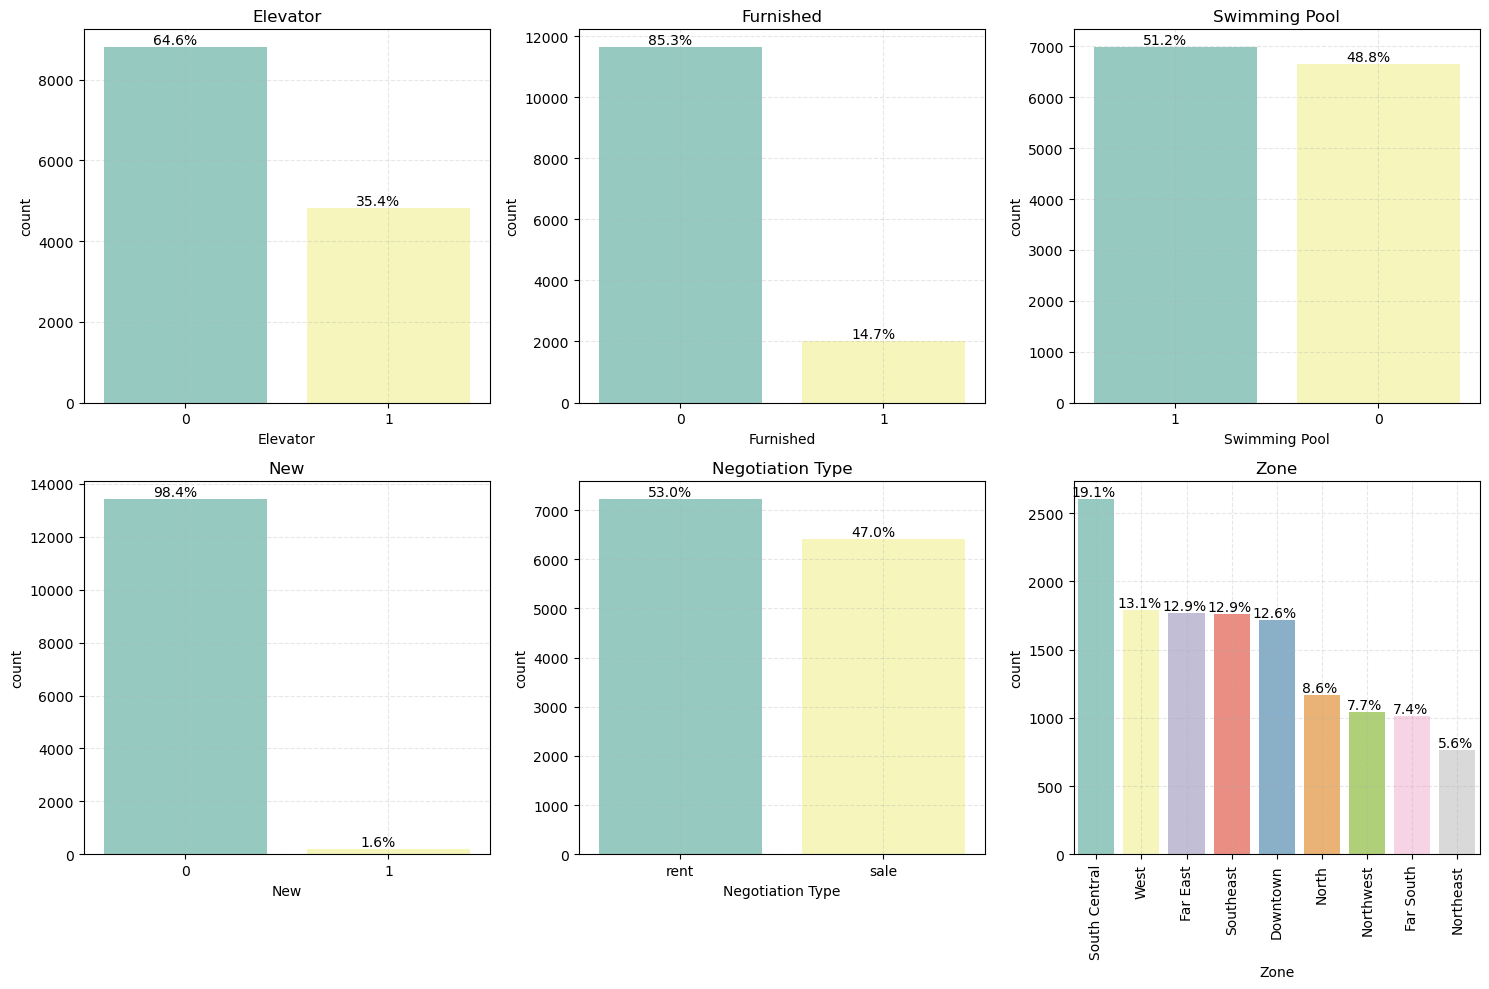

In [23]:
# define kolom yang tidak akan di plot
skipped = ['Longitude', 'Latitude', 'District']

# remove skipped column from list
for i in skipped:
    # remove list
    cat.remove(i)

# set figure
plt.figure(figsize=(15,10))

# countplot
plot_countplot(df,cat,2,3)

# add skipped column to list
for i in skipped:
    # add to list
    cat.append(i)

## Inferential Statistik

In [24]:
for i in df:
    if i != 'Price':
        if num:
            print(i)
            uji_spearman(df,'Price',i)
        else:
            print(i)
            uji_kendall(df,'Price',i)

Condo
koefisien corr = 0.09330723058646771
pvalue = 9.22716622825206e-28

H0 berhasil ditolak: Price berkorelasi dengan Condo

Size
koefisien corr = 0.2760697474248376
pvalue = 4.1951447344383953e-237

H0 berhasil ditolak: Price berkorelasi dengan Size

Rooms
koefisien corr = 0.24045590277458787
pvalue = 1.1883730736643707e-178

H0 berhasil ditolak: Price berkorelasi dengan Rooms

Toilets
koefisien corr = 0.23894695595559376
pvalue = 2.2416642506076667e-176

H0 berhasil ditolak: Price berkorelasi dengan Toilets

Suites
koefisien corr = 0.20577239814496284
pvalue = 2.4750512835619694e-130

H0 berhasil ditolak: Price berkorelasi dengan Suites

Parking
koefisien corr = 0.25354009448846593
pvalue = 4.632963952959235e-199

H0 berhasil ditolak: Price berkorelasi dengan Parking

Elevator
koefisien corr = 0.1501629624756076
pvalue = 1.3021285083615465e-69

H0 berhasil ditolak: Price berkorelasi dengan Elevator

Furnished
koefisien corr = 0.03762791789126768
pvalue = 1.1039915193568172e-05

H0 

## Distribusi Harga Apartment

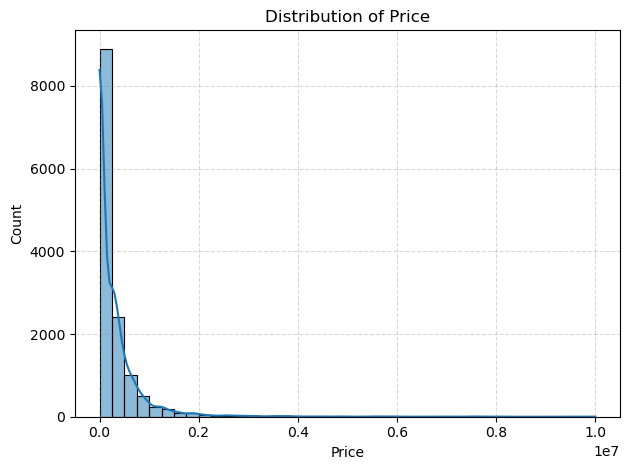

In [25]:
# histogram
plot_histogram(df,['Price'],40)

### Distribusi Harga Berdasarkan Negotiation Type

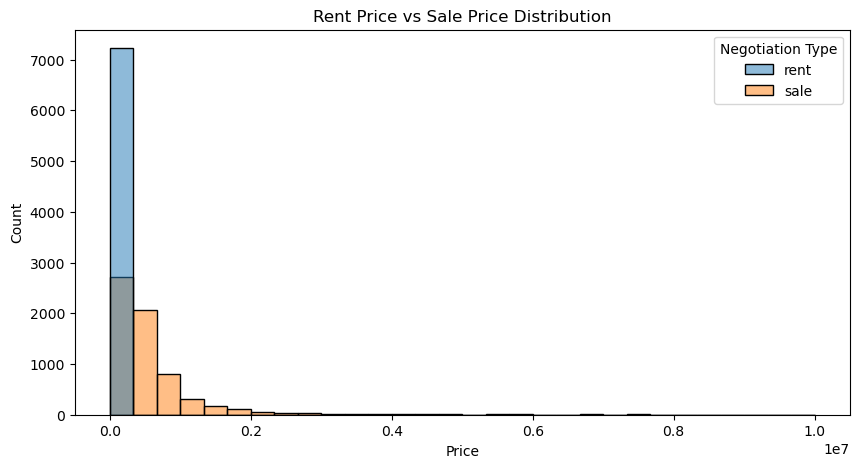

In [26]:
# seg figure
plt.figure(figsize=(10,5))

# histogram rent price vs sale price
sns.histplot(x=df['Price'],
             hue=df['Negotiation Type'],
             bins=30)

# add title
plt.title('Rent Price vs Sale Price Distribution')

# show plot
plt.show()

In [27]:
# filter Negotiation Type = sell
sale = df[df['Negotiation Type']=='sale']

# filter Negotiation Type = rent
rent = df[df['Negotiation Type']=='rent']

In [28]:
# deskriptive apartment for sale
check_deskriptif(sale,['Price'])

,count,mean,std,min,25%,50%,75%,max,skewness,jenis_skewness
Price,6412.0,608624.14005,740451.549192,42000.0,250000.0,380000.0,679000.0,10000000.0,5.09828,skewed


In [29]:
# deskriptice apartment for rent
check_deskriptif(rent,['Price'])

,count,mean,std,min,25%,50%,75%,max,skewness,jenis_skewness
Price,7228.0,3077.669065,3522.830284,480.0,1350.0,2000.0,3300.0,50000.0,4.874126,skewed


## Map

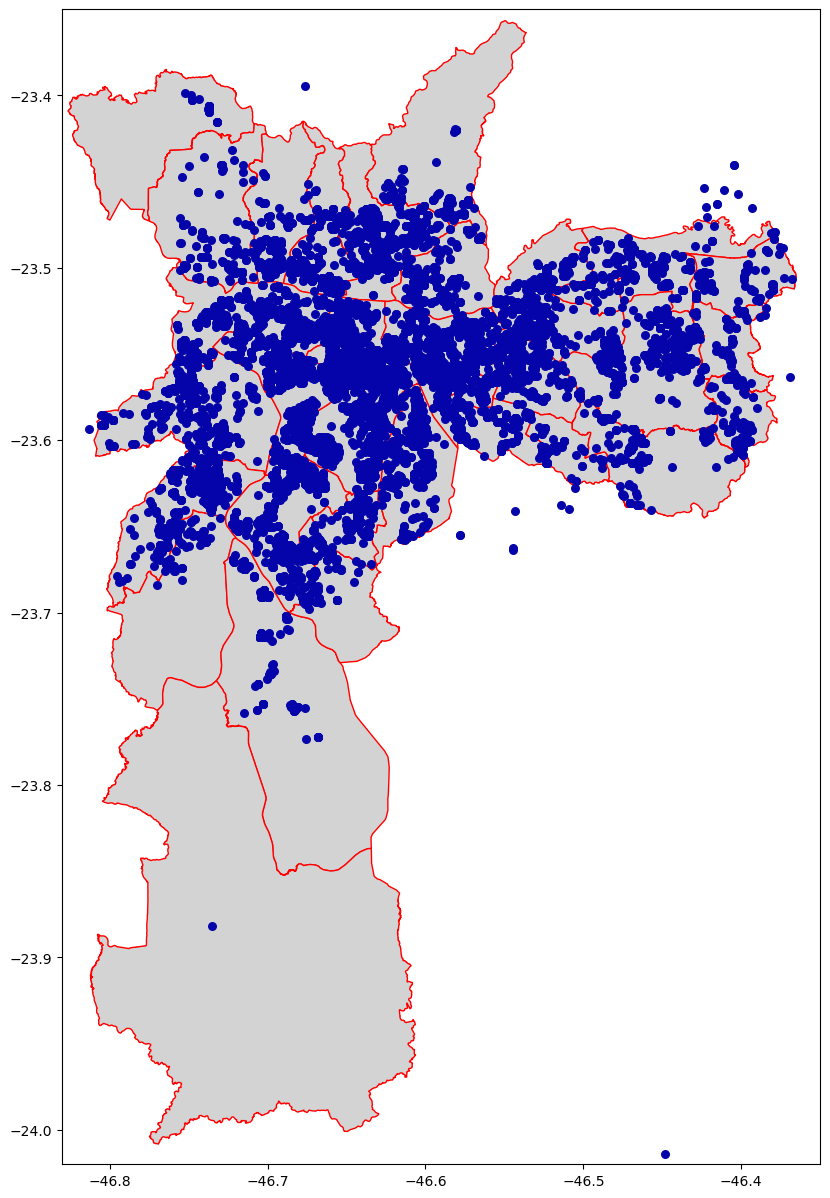

In [30]:
# Load the GeoJSON file
saopaulo_boundary = gpd.read_file('subprefeituras-sp-master/data/subprefeituras-sp.geojson')

# Create the map plot
fig, ax = plt.subplots(figsize=(20, 15))
saopaulo_boundary.plot(ax=ax, color='lightgrey', edgecolor='red')

# Scatter plot with limits set for the entire São Paulo area
ax.scatter(df['Longitude'], df['Latitude'], c='#0504aa', s=30)

# Set limits to focus on São Paulo
ax.set_xlim([-46.83, -46.35])
ax.set_ylim([-24.02, -23.35])

# Show the map
plt.show()


## Top 5 Area Dengan Rata-Rata Harga Tertinggi

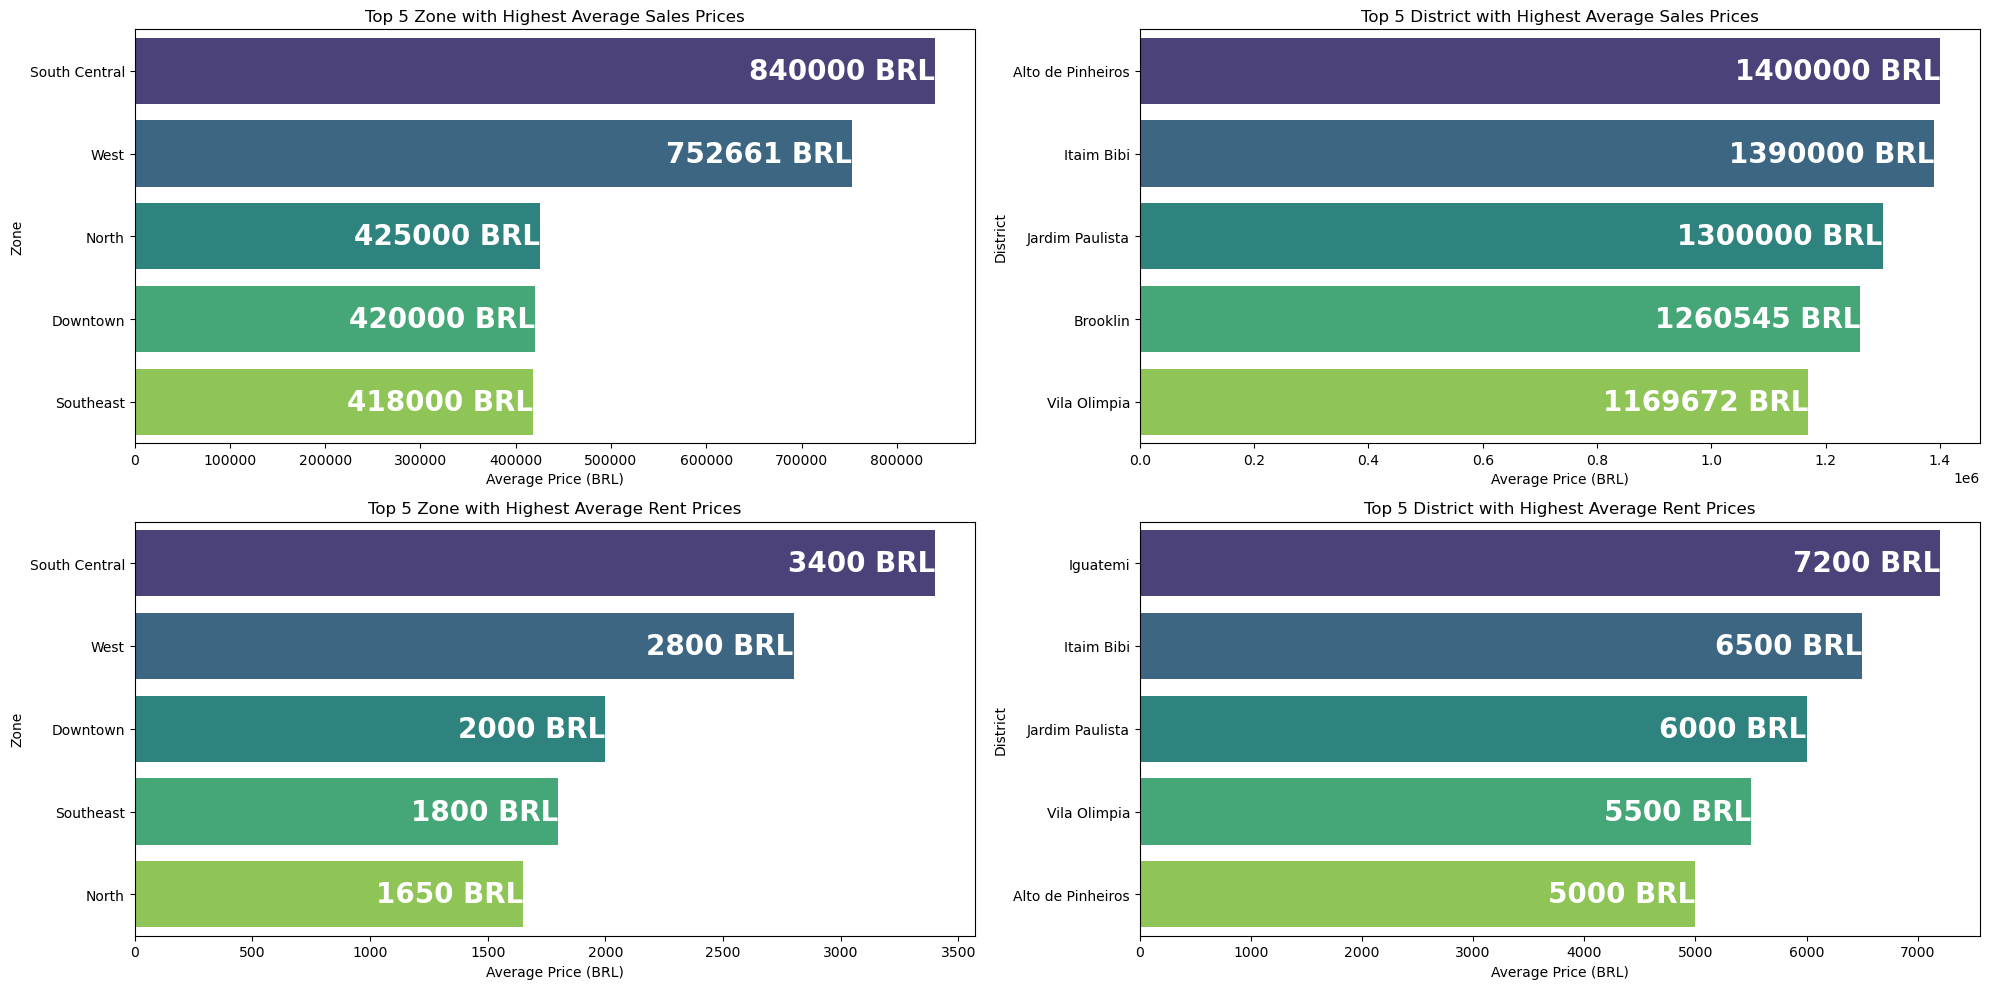

In [31]:
# define top 5 columns
top_5_col = ['Zone', 'District']

# set figure
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# loop barplot
for idx, i in enumerate(top_5_col):
    # Sales Data
    # group by col & calculate median
    average_prices_sale = sale.groupby(i).agg({'Price': 'median'}).reset_index()
    # top 5 apart for sale
    top_5_sale = average_prices_sale.sort_values(by='Price', ascending=False).head(5)

    # axes Sale plot
    ax_sale = axes[0, idx]
    # bar plot
    sns.barplot(x='Price', y=i, data=top_5_sale, palette='viridis', ax=ax_sale)

    # add title
    ax_sale.set_title(f'Top 5 {i} with Highest Average Sales Prices')
    # set x label
    ax_sale.set_xlabel('Average Price (BRL)')
    # set y label
    ax_sale.set_ylabel(i)

    # loop Add annotations
    for p in ax_sale.patches:
        # get width
        width = p.get_width()
        # get height
        height = p.get_height()
        # add annotation
        ax_sale.text(width, p.get_y() + height / 2, f'{int(width)} BRL',
                     ha='right', va='center', color='white', weight='bold', fontsize=20)

    # Rent Data
    # group by col & calculate median
    average_prices_rent = rent.groupby(i).agg({'Price': 'median'}).reset_index()
    # top 5 apart for sale
    top_5_rent = average_prices_rent.sort_values(by='Price', ascending=False).head(5)

    # axes Sale plot
    ax_rent = axes[1, idx]
    # bar plot
    sns.barplot(x='Price', y=i, data=top_5_rent, palette='viridis', ax=ax_rent)

    # add title
    ax_rent.set_title(f'Top 5 {i} with Highest Average Rent Prices')
    # set x label
    ax_rent.set_xlabel('Average Price (BRL)')
    # set y label
    ax_rent.set_ylabel(i)

    # loop Add annotations
    for p in ax_rent.patches:
        # get width
        width = p.get_width()
        # get height
        height = p.get_height()
        # add annotation
        ax_rent.text(width, p.get_y() + height / 2, f'{int(width)} BRL',
                     ha='right', va='center', color='white', weight='bold', fontsize=20)

# show plot
plt.tight_layout()
plt.show()

Bagaimana dengan biaya operasionalnya?

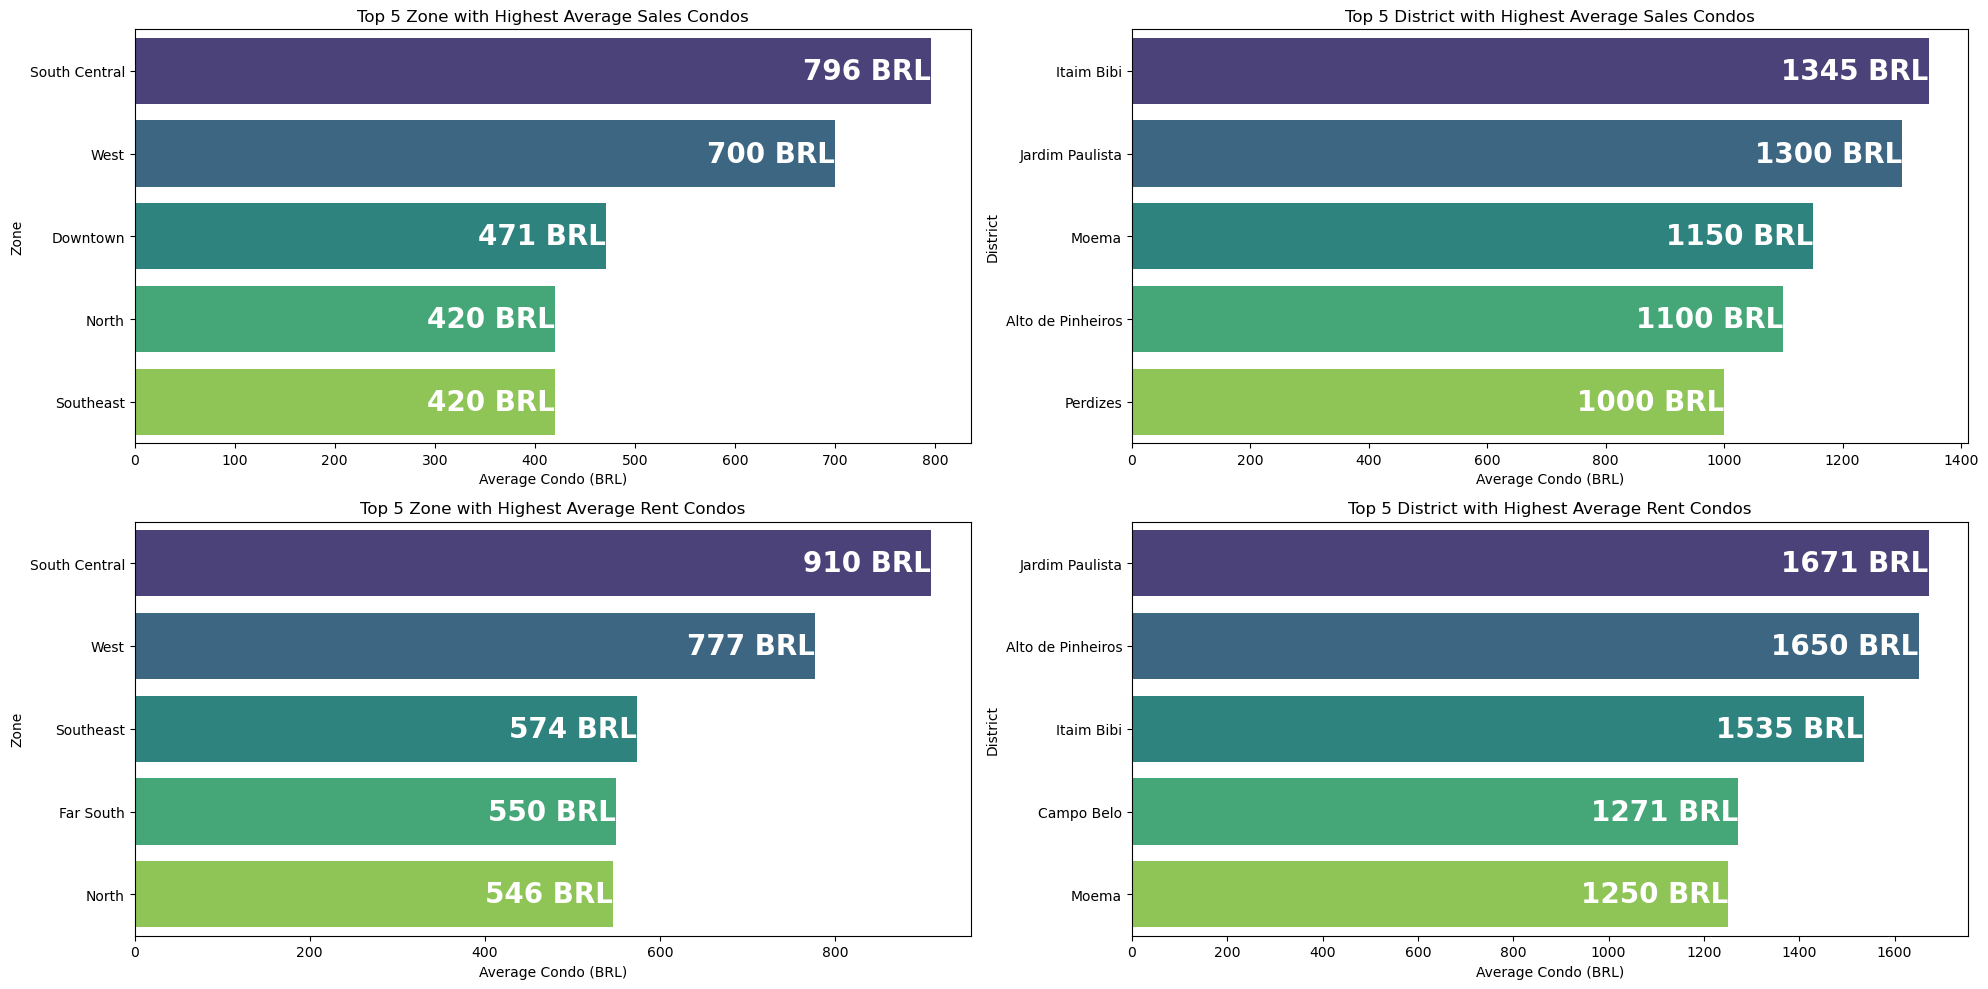

In [32]:
# define top 5 columns
top_5_col = ['Zone', 'District']

# set figure
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# loop barplot
for idx, i in enumerate(top_5_col):
    # Sales Data
    # group by col & calculate median
    average_Condos_sale = sale.groupby(i).agg({'Condo': 'median'}).reset_index()
    # top 5 apart for sale
    top_5_sale = average_Condos_sale.sort_values(by='Condo', ascending=False).head(5)

    # axes Sale plot
    ax_sale = axes[0, idx]
    # bar plot
    sns.barplot(x='Condo', y=i, data=top_5_sale, palette='viridis', ax=ax_sale)

    # add title
    ax_sale.set_title(f'Top 5 {i} with Highest Average Sales Condos')
    # set x label
    ax_sale.set_xlabel('Average Condo (BRL)')
    # set y label
    ax_sale.set_ylabel(i)

    # loop Add annotations
    for p in ax_sale.patches:
        # get width
        width = p.get_width()
        # get height
        height = p.get_height()
        # add annotation
        ax_sale.text(width, p.get_y() + height / 2, f'{int(width)} BRL',
                     ha='right', va='center', color='white', weight='bold', fontsize=20)

    # Rent Data
    # group by col & calculate median
    average_Condos_rent = rent.groupby(i).agg({'Condo': 'median'}).reset_index()
    # top 5 apart for sale
    top_5_rent = average_Condos_rent.sort_values(by='Condo', ascending=False).head(5)

    # axes Sale plot
    ax_rent = axes[1, idx]
    # bar plot
    sns.barplot(x='Condo', y=i, data=top_5_rent, palette='viridis', ax=ax_rent)

    # add title
    ax_rent.set_title(f'Top 5 {i} with Highest Average Rent Condos')
    # set x label
    ax_rent.set_xlabel('Average Condo (BRL)')
    # set y label
    ax_rent.set_ylabel(i)

    # loop Add annotations
    for p in ax_rent.patches:
        # get width
        width = p.get_width()
        # get height
        height = p.get_height()
        # add annotation
        ax_rent.text(width, p.get_y() + height / 2, f'{int(width)} BRL',
                     ha='right', va='center', color='white', weight='bold', fontsize=20)

# show plot
plt.tight_layout()
plt.show()

## Perbandingan Harga Apartment dengan Furnished dan Tidak

In [33]:
# uji signifikansi
uji_mannwhitney(df,'Furnished','Price')

U-Statistic: 10934516.0, P-Value: 1.1107103686550748e-05
tstat = 10934516.0
pvalue = 1.1107103686550748e-05

H0 berhasil ditolak: terdapat perbedaan yang signifikan pada Furnished dan Price



(10934516.0, 1.1107103686550748e-05)

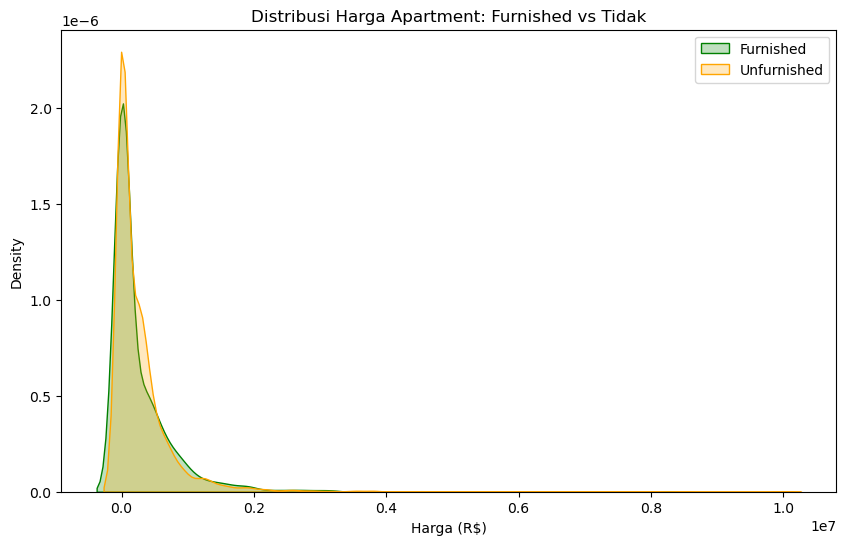

In [34]:
# set figure
plt.figure(figsize=(10, 6))

# histogram  Furnished
sns.kdeplot(df.loc[df['Furnished'] == 1, 'Price'], shade=True, label='Furnished', color='green')
# histogram unfurnished
sns.kdeplot(df.loc[df['Furnished'] == 0, 'Price'], shade=True, label='Unfurnished', color='orange')

# set title
plt.title('Distribusi Harga Apartment: Furnished vs Tidak')
# set x label
plt.xlabel('Harga (R$)')
# add legend
plt.legend()

# show plot
plt.show()

In [35]:
# Statistik deskriptif berdasarkan Furnished
df.groupby('Furnished')['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Furnished,,,,,,,,
0,11638.0,289302.363207,593054.519671,480.0,1800.0,11000.0,360000.0,10000000.0
1,2002.0,278642.594905,577730.573623,720.0,2500.0,5800.0,383750.0,8039200.0


## Perbandingan Harga Apartment Baru dan Bekas

In [36]:
# uji signifikansi
uji_mannwhitney(df,'New','Price')

U-Statistic: 844147.0, P-Value: 9.131026585895732e-25
tstat = 844147.0
pvalue = 9.131026585895732e-25

H0 berhasil ditolak: terdapat perbedaan yang signifikan pada New dan Price



(844147.0, 9.131026585895732e-25)

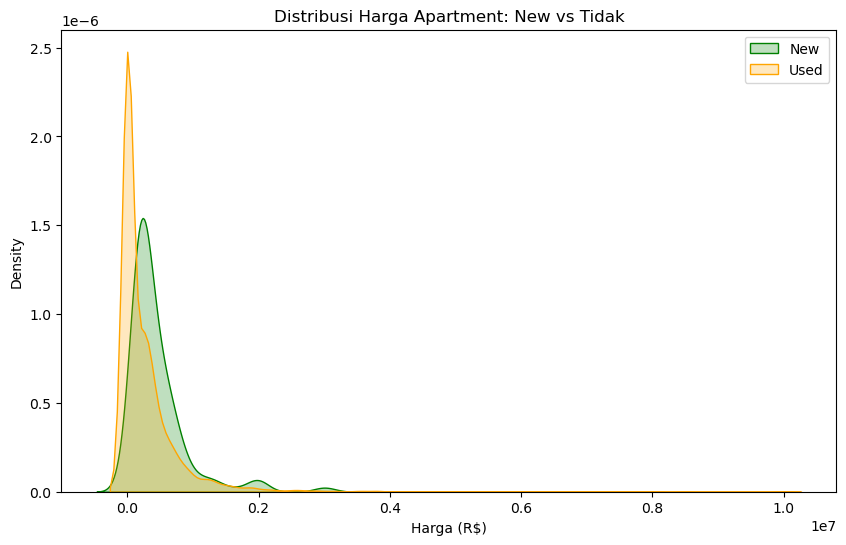

In [37]:
# set figure
plt.figure(figsize=(10, 6))

# histogram  New
sns.kdeplot(df.loc[df['New'] == 1, 'Price'], shade=True, label='New', color='green')
# histogram Used
sns.kdeplot(df.loc[df['New'] == 0, 'Price'], shade=True, label='Used', color='orange')

# set title
plt.title('Distribusi Harga Apartment: New vs Tidak')
# set x label
plt.xlabel('Harga (R$)')
# add legend
plt.legend()

# show plot
plt.show()

In [38]:
# Statistik deskriptif berdasarkan Furnished
df.groupby('New')['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
New,,,,,,,,
0,13427.0,285221.807477,592385.189447,480.0,1800.0,7500.0,358950.0,10000000.0
1,213.0,446338.821596,455922.086859,1250.0,184900.0,265999.0,531000.0,3050003.0


# Feature Engineering

## Handling Duplicate

In [39]:
# cek duplicated value
print(f"\nduplicated values: {round(((df.duplicated().sum())/len(df))*100,2)}% \n{df.duplicated().sum()}\n")


duplicated values: 2.34% 
319



In [40]:
df[df.duplicated()]

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Latitude,Longitude,Zone
165,1300.0,387.0,50.0,2,2,1,1,0,0,0,0,Cidade Tiradentes,rent,-23.582576,-46.417478,Far East
203,999.0,0.0,70.0,2,2,1,1,0,0,0,0,Ermelino Matarazzo,rent,-23.494694,-46.478125,Far East
204,888.0,0.0,70.0,2,2,1,1,0,0,0,0,Ermelino Matarazzo,rent,-23.494694,-46.478125,Far East
207,8000.0,1400.0,132.0,3,2,1,1,0,0,0,0,Iguatemi,rent,-23.585672,-46.681216,Far East
208,8000.0,1400.0,132.0,3,2,1,1,0,0,0,0,Iguatemi,rent,-23.585672,-46.681216,Far East
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13105,189000.0,0.0,40.0,2,1,0,1,0,0,1,0,Sao Mateus,sale,-23.611443,-46.459974,Far East
13115,189000.0,0.0,40.0,2,1,0,1,0,0,1,0,Sao Mateus,sale,-23.611443,-46.459974,Far East
13272,233750.0,100.0,47.0,2,2,1,1,1,0,0,0,Vila Jacui,sale,-23.501856,-46.456386,Far East
13496,660000.0,450.0,107.0,3,2,1,2,0,0,0,0,Cidade Ademar,sale,-23.660596,-46.667492,Far South


Terdapat 2.34% atau 319 duplicate values, tetapi karena data tidak memilik primary key dan juga sangat memungkinkan untuk 2 unit berada dalam satu gedung apartment yans sama (latititude dan longitude sama). Sehingga memungkinkan pula unit unit memiliki spesifikasi, harga jual, bahkan agen properti yang sama.

## Handling Cardinality

In [41]:
for col in df:
    print(f'{col}-#nunique: {df[col].nunique()}')

Price-#nunique: 1881
Condo-#nunique: 1415
Size-#nunique: 339
Rooms-#nunique: 8
Toilets-#nunique: 8
Suites-#nunique: 7
Parking-#nunique: 10
Elevator-#nunique: 2
Furnished-#nunique: 2
Swimming Pool-#nunique: 2
New-#nunique: 2
District-#nunique: 96
Negotiation Type-#nunique: 2
Latitude-#nunique: 8405
Longitude-#nunique: 8451
Zone-#nunique: 9


- Kolom-kolom yang numerik terlihat normal.
- Beberapa kolom kategorik memiliki terlalu banyak/sedikit unique value seperti:
    - 'Longitude' (8451 unique value) dan 'Latitude' (8405 unique value): Kedua kolom ini tidak akan dipakai dalam modeling karena memiliki terlalu banyak unique value dan juga isinya sudah diwakilkan oleh 'District' dan 'Zone' yang juga berisi informasi tentang lokasi.
    - 'District' (96 unique value): Telah dikelompokkan ulang sesuai dengan [pembagian wilayahnya](https://wikitravel.org/en/S%C3%A3o_Paulo) (West, Downtown, Norteast, etc.) pada kolom 'Zone'. Maka dari itu, 'District' dapat dihapus dari dataset.

## Split Data

Untuk menghindari data leakage, spliting data perlu dilakukan sebelum melakukan handling outlier, missung value, dll. Data akan di-split dengan perbandingan 80:20.

In [42]:
# fitur & target
X = df.drop(columns='Price')
y = df[['Price']]

#split
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2,
                                                 random_state=42)

# train-test set
train = pd.concat([X_train,y_train],axis=1)
test = pd.concat([X_test,y_test],axis=1)

In [43]:
# divide numeric & categoric
X_num = num.copy()
X_cat = cat.copy()

# remove target
X_num.remove('Price')

# check numerik-kategorik
print(f'numerik: {X_num}')
print(f'kategorik: {X_cat}')

numerik: ['Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking']
kategorik: ['Elevator', 'Furnished', 'Swimming Pool', 'New', 'Negotiation Type', 'Zone', 'Longitude', 'Latitude', 'District']


In [44]:
# save train & test
X_train_org = X_train.copy()
X_test_org  = X_test.copy()
y_test_org  = y_test.copy()
y_train_org = y_train.copy()

In [45]:
# Load
X_train = X_train_org.copy()
X_test  = X_test_org.copy()
y_test  = y_test_org.copy()
y_train = y_train_org.copy()

## Handling Missing Value

Seperti yang sudah dijelaskan di atas bahwa terdapat non-standard missing value pada kolom 'Condo', yaitu pada value "0" yang menandakan nilai yang tidak diketahui.

In [46]:
# filter missing value pada COndo
mv_condo = X_train[X_train['Condo']==0]

# check shape
print(mv_condo.shape)

# check missing value
mv_condo.sample(5)

(1597, 15)


,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Latitude,Longitude,Zone
1889,0.0,60.0,3,2,1,1,0,0,0,0,Lapa,rent,-23.521025,-46.703831,West
3159,0.0,44.0,2,1,0,1,0,0,1,0,Sao Lucas,rent,-23.600564,-46.542870,Northeast
5004,0.0,112.0,3,3,1,2,1,0,1,0,Vila Olimpia,sale,-23.604197,-46.678332,South Central
1334,0.0,35.0,1,2,1,1,0,0,1,0,Sacoma,rent,-23.615481,-46.605486,Southeast
4913,0.0,67.0,2,2,1,1,1,0,0,1,Vila Madalena,sale,-23.562150,-46.692518,West


In [47]:
for i in X_train:
    if i != 'Condo':
        if num:
            print(i)
            uji_spearman(X_train,'Condo',i)
        else:
            print(i)
            uji_kendall(X_train,'Condo',i)

Size
koefisien corr = 0.6144218460459618
pvalue = 0.0

H0 berhasil ditolak: Condo berkorelasi dengan Size

Rooms
koefisien corr = 0.4001690610111512
pvalue = 0.0

H0 berhasil ditolak: Condo berkorelasi dengan Rooms

Toilets
koefisien corr = 0.38659014353610427
pvalue = 0.0

H0 berhasil ditolak: Condo berkorelasi dengan Toilets

Suites
koefisien corr = 0.34519566667282436
pvalue = 5.7255589178353865e-303

H0 berhasil ditolak: Condo berkorelasi dengan Suites

Parking
koefisien corr = 0.5031940909104009
pvalue = 0.0

H0 berhasil ditolak: Condo berkorelasi dengan Parking

Elevator
koefisien corr = 0.018088248979542584
pvalue = 0.05883209482828474

H0 gagal ditolak Condo  TIDAK berkorelasi dengan Elevator

Furnished
koefisien corr = 0.14688240388102974
pvalue = 1.1049733112461188e-53

H0 berhasil ditolak: Condo berkorelasi dengan Furnished

Swimming Pool
koefisien corr = 0.21098298186202535
pvalue = 4.809272613789428e-110

H0 berhasil ditolak: Condo berkorelasi dengan Swimming Pool

New
koe

In [48]:
mv_condo.groupby('Negotiation Type').size().sort_values(ascending=False)

Negotiation Type
sale    1085
rent     512
dtype: int64

In [49]:
mv_condo.groupby('Zone').size().sort_values(ascending=False)

Zone
Far East         418
Southeast        208
South Central    191
North            177
West             137
Northwest        134
Downtown         120
Northeast        110
Far South        102
dtype: int64

In [50]:
mv_condo[mv_condo['Zone']=='Far East'].groupby('District').size().sort_values(ascending=False)

District
Ermelino Matarazzo    47
Itaquera              34
Sao Mateus            32
Artur Alvim           31
Sao Miguel            27
Cidade Tiradentes     27
Jardim Helena         25
Vila Jacui            23
Cangaiba              22
Cidade Lider          19
Parque do Carmo       18
Iguatemi              17
Jose Bonifacio        17
Guaianazes            16
Ponte Rasa            15
Vila Curuca           15
Itaim Paulista        14
Lajeado               12
Sao Rafael             7
dtype: int64

MAR: dapat terjadi karena beberapa alasan.
1. Data Entry Errors: Human error atau system error ketika memasukkan data.
2. Variability Data Sources: berdasarkan deskripsi data di atas, dataset ini merupakan kumpulan harga apartment dari berbagai sumber yang bisa jadi beberapa sumber tidak memiliki informasi lengkap mengenai biaya kondomium.

In [51]:
# replace 0 with nan
X_train['Condo'] = X_train['Condo'].replace(0, np.nan)

# median per district
median_district = X_train.groupby('District')[['Condo']].median()

# fill missing value dengan median per district
X_train['Condo'] = X_train['Condo'].fillna(X_train.groupby('District')['Condo'].transform('median'))

# fill missing value dengan median per district (test)
X_test['Condo'] = X_test['Condo'].fillna(X_train.groupby('District')['Condo'].transform('median'))

# check
print('train', X_train.isna().sum().sum())
print('test', X_test.isna().sum().sum())

train 0
test 0


In [52]:
# save train & test
X_train_nomv = X_train.copy()
X_test_nomv  = X_test.copy()
y_test_nomv  = y_test.copy()
y_train_nomv = y_train.copy()

In [53]:
# Load
X_train = X_train_nomv.copy()
X_test  = X_test_nomv.copy()
y_test  = y_test_nomv.copy()
y_train = y_train_nomv.copy()

## Handling Outlier

In [54]:
# check outlier
check_outlier(X_train,X_num)

,batas_atas,batas_bawah,persentase
Condo,2421.000000,-1142.000000,3.72
Size,226.000000,-82.000000,3.70
Rooms,4.654333,-0.019803,0.20
Toilets,2.000000,2.000000,39.73
Suites,1.000000,1.000000,36.22
Parking,5.000000,-2.000000,0.16


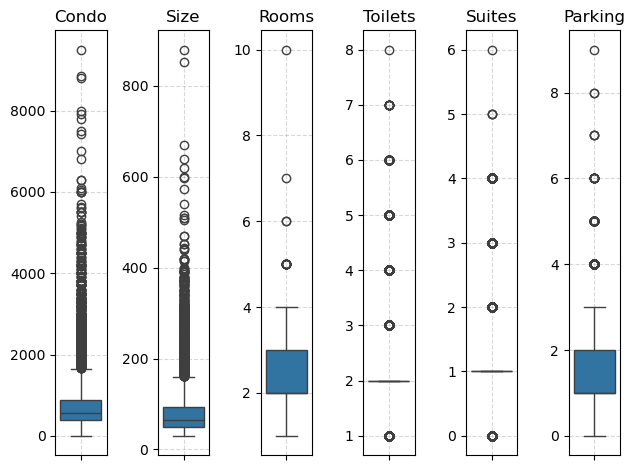

In [55]:
# box plot
plot_boxplot(X_train,X_num)

In [56]:
# cek deskriptif
num_desc = check_deskriptif(X_train,X_num)

# cek skewness
num_desc[['skewness','jenis_skewness']]

,skewness,jenis_skewness
Condo,3.505451,skewed
Size,3.110908,skewed
Rooms,0.367058,normal
Toilets,1.594305,skewed
Suites,1.469252,skewed
Parking,1.864687,skewed


In [57]:
# set column sesuai metode caping
## outlier extreeme
iqr_fold_3 = X_num.copy()

# define collumn that will not handle outlier with iqr
dropped = ['Rooms','Toilets', 'Suites', 'Condo']
# drop distribusi normal
for i in dropped:
    # drop
    iqr_fold_3.remove(i)

# distribusi normal
normal = ['Rooms']

# skew dist capping
winsoriser_cap = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=iqr_fold_3)
# fit transform ke train
X_train[iqr_fold_3] = winsoriser_cap.fit_transform(X_train[iqr_fold_3])
# transform ke test
X_test[iqr_fold_3] = winsoriser_cap.transform(X_test[iqr_fold_3])

# normal dist capping outlier
winsoriser_cap = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=1.5,
                             variables=normal)
# fit transform ke train
X_train[normal] = winsoriser_cap.fit_transform(X_train[normal])
# transform ke test
X_test[normal] = winsoriser_cap.transform(X_test[normal])

# re-add dropped columns
for i in dropped:
    # add
    iqr_fold_3.append(i)

In [58]:
# check outlier
check_outlier(X_train,X_num)

,batas_atas,batas_bawah,persentase
Condo,2421.000000,-1142.000000,3.72
Size,226.000000,-82.000000,0.00
Rooms,4.628938,0.001927,0.00
Toilets,2.000000,2.000000,39.73
Suites,1.000000,1.000000,36.22
Parking,5.000000,-2.000000,0.00


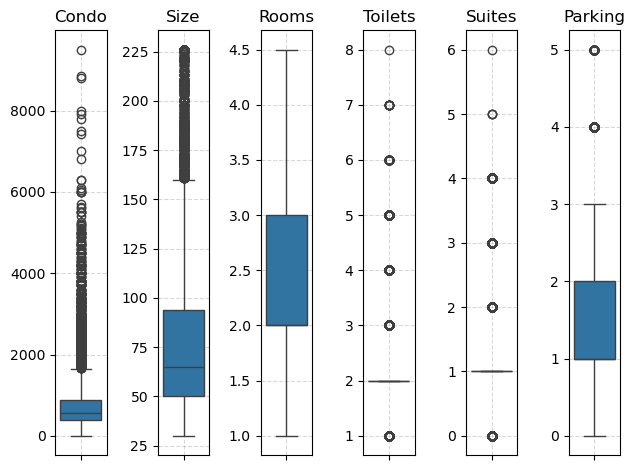

In [59]:
# box plot
plot_boxplot(X_train,X_num)

In [60]:
# cek deskriptif
num_desc = check_deskriptif(X_train,X_num)

# cek skewness
num_desc[['skewness','jenis_skewness']]

,skewness,jenis_skewness
Condo,3.505451,skewed
Size,1.674205,skewed
Rooms,0.230652,normal
Toilets,1.594305,skewed
Suites,1.469252,skewed
Parking,1.664504,skewed


In [61]:
# save train & test
X_train_cap = X_train.copy()
X_test_cap  = X_test.copy()
y_test_cap  = y_test.copy()
y_train_cap = y_train.copy()

In [62]:
# Load
X_train = X_train_cap.copy()
X_test  = X_test_cap.copy()
y_test  = y_test_cap.copy()
y_train = y_train_cap.copy()

## Feature Selection

In [63]:
# define column that will be dropped
dropped = ['Longitude', 'Latitude', 'District']

# drop from train
X_train.drop(columns=dropped,inplace=True)

# drop from test
X_test.drop(columns=dropped,inplace=True)

# drop distribusi normal
for i in dropped:
    # drop
    X_cat.remove(i)

In [64]:
# save train & test
X_train_FS_2 = X_train.copy()
X_test_FS_2  = X_test.copy()
y_test_FS_2  = y_test.copy()
y_train_FS_2 = y_train.copy()

In [65]:
# Load
X_train = X_train_FS_2.copy()
X_test  = X_test_FS_2.copy()
y_test  = y_test_FS_2.copy()
y_train = y_train_FS_2.copy()

## Data Transformation

### Scaling

In [66]:
# Scaler
minmaX_scaler = MinMaxScaler()

# loop scaling
for i in X_num:
    # scaling train
    X_train[X_num] = minmaX_scaler.fit_transform(X_train[X_num])
    # scaling test
    X_test[X_num] = minmaX_scaler.transform(X_test[X_num])

# hasil
X_train.head(2)

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Negotiation Type,Zone
3717,0.368355,0.892857,0.571429,0.428571,0.500000,0.8,0,0,0,0,rent,South Central
12432,0.054637,0.142857,0.571429,0.142857,0.166667,0.2,0,0,1,0,sale,Northwest


In [67]:
# save train & test
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()
y_test_scaled  = y_test.copy()
y_train_scaled = y_train.copy()

In [68]:
# Load
X_train = X_train_scaled.copy()
X_test  = X_test_scaled.copy()
y_test  = y_test_scaled.copy()
y_train = y_train_scaled.copy()

### Encoding

In [69]:
# one hot column
ohe_col = ['Negotiation Type', 'Zone']

# define encoder
encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')

# Encode train
X_train_encoded = encoder.fit_transform(X_train[ohe_col])

# convert to df
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(ohe_col), index=X_train.index)

# Drop original column & merge encoded column train
X_train = X_train.drop(columns=ohe_col).join(X_train_encoded_df)

# Encode test
X_test_encoded = encoder.transform(X_test[ohe_col])

# convert to df
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(ohe_col), index=X_test.index)

# Drop original column & merge encoded column test
X_test = X_test.drop(columns=ohe_col).join(X_test_encoded_df)

# hasil
X_train.head(2)

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Negotiation Type_rent,Negotiation Type_sale,Zone_Downtown,Zone_Far East,Zone_Far South,Zone_North,Zone_Northeast,Zone_Northwest,Zone_South Central,Zone_Southeast,Zone_West
3717,0.368355,0.892857,0.571429,0.428571,0.500000,0.8,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12432,0.054637,0.142857,0.571429,0.142857,0.166667,0.2,0,0,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [70]:
# save train & test
X_train_transform = X_train.copy()
X_test_transform  = X_test.copy()
y_test_transform  = y_test.copy()
y_train_transform = y_train.copy()

In [71]:
# Load
X_train = X_train_transform.copy()
X_test  = X_test_transform.copy()
y_test  = y_test_transform.copy()
y_train = y_train_transform.copy()

## Column Transformer

In [72]:
X_cat

['Elevator', 'Furnished', 'Swimming Pool', 'New', 'Negotiation Type', 'Zone']

In [74]:
# assign column sesuai perlakuan
# one-hot kolom
ohe_col = ohe_col.copy()

# scaling kolom
scale_col = X_num.copy()

# encoded columns
encoded = X_cat.copy()

# drop unencoded columns
for o in ohe_col:
    # remove
    encoded.remove(o)

# pipeline one-hot
ohe_pipeline = Pipeline([
    ('oh_enc',OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
])

# pipeline num
pipe_num = Pipeline([
    ('minmax_scaler', MinMaxScaler())
])

# Transformer Column
ct_prep = ColumnTransformer([
    ('numeric', pipe_num, scale_col),
    ('oh_encode',ohe_pipeline, ohe_col),
    ('encoded','passthrough',encoded)
])

# check transformer columns
ct_prep

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('minmax_scaler',
                                                  MinMaxScaler())]),
                                 ['Condo', 'Size', 'Rooms', 'Toilets', 'Suites',
                                  'Parking']),
                                ('oh_encode',
                                 Pipeline(steps=[('oh_enc',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Negotiation Type', 'Zone']),
                                ('encoded', 'passthrough',
                                 ['Elevator', 'Furnished', 'Swimming Pool',
                                  'New'])])

# Model Definition

## KNN

In [77]:
# pipeline model
pipe_knn = Pipeline([
    ('prep', ct_prep),
    ('model', KNeighborsRegressor())
])

# cek
pipe_knn

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Condo', 'Size', 'Rooms',
                                                   'Toilets', 'Suites',
                                                   'Parking']),
                                                 ('oh_encode',
                                                  Pipeline(steps=[('oh_enc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Negotiation Type', 'Zone']),
                                                 ('encoded', 'passthrough',
                                                  ['Elevator', 'Furnished',
                                                   'Swimming Pool', 'New'])])),
                ('model', KNeighborsRegressor())])

## SVM

In [76]:
# pipeline model
pipe_svr = Pipeline([
    ('prep', ct_prep),
    ('model', SVR())
])

# cek
pipe_svr

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Condo', 'Size', 'Rooms',
                                                   'Toilets', 'Suites',
                                                   'Parking']),
                                                 ('oh_encode',
                                                  Pipeline(steps=[('oh_enc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Negotiation Type', 'Zone']),
                                                 ('encoded', 'passthrough',
                                                  ['Elevator', 'Furnished',
                                                   'Swimming Pool', 'New'])])),
                ('model', SVR())])

## Decision Tree

In [79]:
# pipeline model
pipe_dt = Pipeline([
    ('prep', ct_prep),
    ('model', DecisionTreeRegressor(random_state=42))
])

# cek
pipe_dt

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Condo', 'Size', 'Rooms',
                                                   'Toilets', 'Suites',
                                                   'Parking']),
                                                 ('oh_encode',
                                                  Pipeline(steps=[('oh_enc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Negotiation Type', 'Zone']),
                                                 ('encoded', 'passthrough',
                                                  ['Elevator', 'Furnished',
                                                   'Swimming Pool', 'New'])])),
                ('model', DecisionTreeRegressor(random_state=42))])

## Random Forest 

In [80]:
# pipeline model
pipe_rf = Pipeline([
    ('prep', ct_prep),
    ('model', RandomForestRegressor(random_state=42))
])

# cek
pipe_rf

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Condo', 'Size', 'Rooms',
                                                   'Toilets', 'Suites',
                                                   'Parking']),
                                                 ('oh_encode',
                                                  Pipeline(steps=[('oh_enc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Negotiation Type', 'Zone']),
                                                 ('encoded', 'passthrough',
                                                  ['Elevator', 'Furnished',
                                                   'Swimming Pool', 'New'])])),
                ('model', RandomForestRegressor(random_state=42))])

## XGBoost

In [84]:
# pipeline model
pipe_xgb = Pipeline([
    ('prep', ct_prep),
    ('model', xgb.XGBRegressor())
])

# cek
pipe_xgb

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Condo', 'Size', 'Rooms',
                                                   'Toilets', 'Suites',
                                                   'Parking']),
                                                 ('oh_encode',
                                                  Pipeline(steps=[('oh_enc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Negotiation Type', 'Zone']),
                                                 ('encoded', 'passthrough',
                                                  ['Elevator', 'Furnished'...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

# Model Training

In [85]:
# Load
X_train = X_train_FS_2.copy()
X_test  = X_test_FS_2.copy()
y_test  = y_test_FS_2.copy()
y_train = y_train_FS_2.copy()

In [86]:
# Training KNN
pipe_knn.fit(X_train, y_train)

# Training SVM
pipe_svr.fit(X_train, y_train)

# Training decision tree
pipe_dt.fit(X_train, y_train)

# Training random forest
pipe_rf.fit(X_train, y_train)

# Training KNN
pipe_xgb.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Condo', 'Size', 'Rooms',
                                                   'Toilets', 'Suites',
                                                   'Parking']),
                                                 ('oh_encode',
                                                  Pipeline(steps=[('oh_enc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Negotiation Type', 'Zone']),
                                                 ('encoded', 'passthrough',
                                                  ['Elevator', 'Furnished'...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [ ]:
# crossval knn
knn_train_cross_val = cross_val_score(pipe_knn,
                                     X_train,
                                     y_train,
                                     cv=5,
                                     scoring="neg_root_mean_squared_error")

# crossval svm
svm_train_cross_val = cross_val_score(pipe_svr,
                                     X_train,
                                     y_train,
                                     cv=5,
                                     scoring="neg_root_mean_squared_error")

# crossval dt
dt_train_cross_val = cross_val_score(pipe_dt,
                                     X_train,
                                     y_train,
                                     cv=5,
                                     scoring="neg_root_mean_squared_error")

# crossval rf
rf_train_cross_val = cross_val_score(pipe_rf,
                                     X_train,
                                     y_train,
                                     cv=5,
                                     scoring="neg_root_mean_squared_error")

# crossval boost
boost_train_cross_val = cross_val_score(pipe_xgb,
                                     X_train,
                                     y_train,
                                     cv=5,
                                     scoring="neg_root_mean_squared_error")